## HW 3

In [1]:
import Pkg;
Pkg.add("BenchmarkTools")
using BenchmarkTools
using Plots
using Statistics
using Random
using Distributions

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


## Continuous Ant Algorithm

The basis of this implementation was taken from the lecture notes on Dorigos' ant system.

### Global Info

In [2]:
RANGE_MIN=-30
RANGE_MAX=30
PROBLEM_RANGE=RANGE_MAX-RANGE_MIN

60

In [3]:
function get_interval_range(num_intervals)
    # num_intervals: number of intervals to split the space 
    
    # num_intervals is interpretted based on Equation (10.3) in the HW 3 description.
    # Therefore we divide the problem domain into num_intervals - 1 intervals

    return PROBLEM_RANGE/(num_intervals-1)    
    
end

get_interval_range (generic function with 1 method)

In [4]:
function get_interval_index(num_intervals, value)
    # num_intervals: number of intervals to split the space
    # value: find the index of this value

    # Print out any values that outside of the defined problem range.
    if value < RANGE_MIN || value > RANGE_MAX
        println(value)
    end

    interval_size = get_interval_range(num_intervals)
    index = ((value - RANGE_MIN) / interval_size) + 1

    # truncate and cast the index to an integer.
    index = Int(trunc(index))
    
    #println("for value ", value, " the index is ", index) 
    
    return index
end

get_interval_index (generic function with 1 method)

In [5]:
function update_pheromones(pheromones, n, num_intervals, ant_solution, fitness, Q)
    # pheromones: pheromone matrix
    # n: number of dimensions in the ant_solution (and the max value in the first index of pheromones)
    # num_intervals: number of intervals to split the space 
    #     (and the num_intervals - 1 is the max value in the second index of pheromones) 
    # ant_solution: one of the ant solution
    # fitness: fitness of the solution
    # Q: pheromone increment
    
    # deposit pheromone 
    for i in 1:n
        interval_index = get_interval_index(num_intervals, ant_solution[i])
        pheromones[i, interval_index] += Q/fitness
        #println("Update index, ", i, ", ", interval_index, " for value ", ant_solution[i])
        #print(" with ", Q/fitness, " pheromones")
    end

    return pheromones
end

update_pheromones (generic function with 1 method)

In [6]:
function continuous_ant_algo(f, n, num_generations, m, alpha, Q, rho, tau_naught, num_intervals, mutation_rate, m_best)
    # f: continuous value function to optimize
    # n: number of dimensions
    # num_generations: number of iterations (generations) to run
    # m: number of ants
    # alpha: pheromone importance factor
    # Q: pheromone deposit factor
    # rho: pheromone evaporation factor
    # tau_naught: initial pheronmone value
    # num_intervals: number of intervals to split the space
    # mutation_rate: probability of choosing a random value for every dimension of every solution
    #      Note: mutation rate does not apply to elitist solutions
    # m_best: how many of the best ant solutions to use for depositing pheromones
    #      value must be > 0 and <= m (number of ants)
       
    improvements = []
    interval_size = get_interval_range(num_intervals)
    best_solutions = []
    # these two variables are used to verify the mutation rate.
    num_mutations = 0 
    possible_mutations = 0
    
    # Initialize pheromone matrix with tau_naught
    pheromones = ones(n, num_intervals - 1) * tau_naught

    best_fitness_history = []
    best_fitness = Inf
    best_solution = []
    first_run = true
    
    for iteration in 1:num_generations
        # Initialize storage for ant trials
        ant_solutions = []
        # start with m ant generations, may decrease based on the number of elitist ants.
        num_ant_generations = m

        # There are no elitist ants on the first run, but after that we need to count them as solutions.
        if !first_run
            # two elitist ants
            num_ant_generation = num_ant_generations - 2 
            push!(ant_solutions, best_solutions[1])
            push!(ant_solutions, best_solutions[2])
            # Set the fitness of the best solution to infinity so that we can recalculate the elitist ants.
            best_solutions[1] = (best_solutions[1][1], Inf)
            best_solutions[2] = (best_solutions[2][1], Inf)
        end
        first_run = false
        
        # let the ants run ...
        for ant in 1:num_ant_generations
            ant_solution = zeros(n)
            
            for dimension_index in 1:n
                if rand() < mutation_rate
                    # random value for this dimension of the solution.
                    # assume that all ranges are centered on 0.
                    ant_solution[dimension_index] = ((rand()-.5) * PROBLEM_RANGE) 
                    num_mutations = num_mutations + 1
                else    
                    # Calculate probabilities
                    probabilities = zeros(num_intervals-1)
                    for i in 1:num_intervals-1
                        probabilities[i] = pheromones[dimension_index,i]^alpha 
                    end
                    # normalize probability vector
                    probabilities /= sum(probabilities)
                    # println(probabilities)
                    # Choose next interval of the problem range by sampling from probabilities
                    interval = rand(Categorical(probabilities))

                    # use the interval index to calculate a random value in this index of the solution.
                    ant_solution[dimension_index] = ((rand() * interval_size) + RANGE_MIN) + ((interval-1) * interval_size) 
                    #print(interval, ", ")
                    #println(ant_solution[dimension_index])
                end       
                possible_mutations = possible_mutations + 1
            end
            
            # store the solution and the fitness
            fitness = f(ant_solution)
            push!(ant_solutions, (ant_solution, fitness))

            # record best solution found
            if fitness<best_fitness
                best_solution = ant_solution
                best_fitness = fitness
                # println("improvement: ", best_fitness, " solution: ", best_solution)               
            end
        end
        
        # Update pheromones
        # evaporation
        pheromones *= (1-rho)

        # sort the ant solutions based on the fitness.
        sort!(ant_solutions, by = x -> x[2])
        
        # println(ant_solutions)
        # ants deposit pheromone on intervals trails
        # only do this for the m_best solutions indicated.
        for ant in 1:m_best
            ant_solution = ant_solutions[ant][1]
            fitness = ant_solutions[ant][2]
            #print(fitness, ", ")
            
            pheromones = update_pheromones(pheromones, n, num_intervals, ant_solution, fitness, Q)
            
            #println(ant_solution)

            # calculate the elitist ants for the next iteration
            if size(best_solutions)[1] < 2
                # if there are not 2 elitist ants yet, then add the current ant.
                push!(best_solutions, (ant_solution, fitness))
            else                           
                # replace an elitist any if the current ant is better than any of them.
                if fitness < best_solutions[1][2] || fitness < best_solutions[2][2]
                    if best_solutions[1][2] < best_solutions[2][2]
                        best_solutions[2] = (ant_solution, fitness)
                    else
                        best_solutions[1] = (ant_solution, fitness)
                    end
                end
            end
        end
        #println()
        #println()
        # push!(improvements, best_length)
        push!(best_fitness_history , best_fitness)

    end
    
    # Print results
    #println("Best solution: ", best_solution)
    #println("Fitness: ", best_fitness)
    #println("Mutation rate is ", num_mutations / possible_mutations)
    #display(heatmap(pheromones,
    #    c=cgrad([:blue, :yellow]),
    #    xlabel="x values", ylabel="y values",
    #    title="pheromone heatmap"))
    
    return best_solution, best_fitness, best_fitness_history
end

continuous_ant_algo (generic function with 1 method)

In [7]:
function ackley(x)
    # find the dimension of the variable. save it in d.
    d = size(x)[1]
    # the Ackley as defined by https://www.sfu.ca/~ssurjano/ackley.html
    return (-20 * exp(-0.2 * sqrt((1 / d) * sum([val^2 for val in x]))) - exp((1 / d) * sum([cos(2π * val) for val in x])) + 20 + exp(1))
end

ackley (generic function with 1 method)

## a.) 

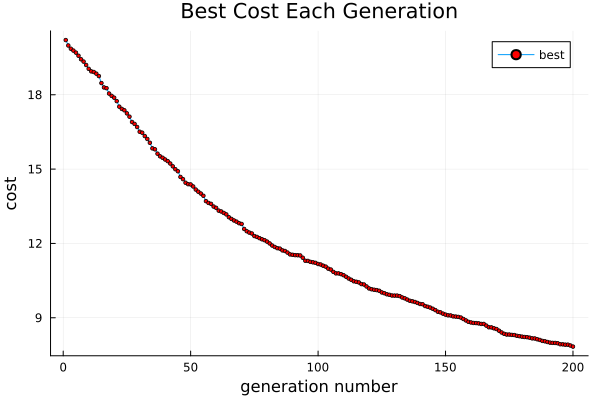

BenchmarkTools.Trial: 17 samples with 1 evaluation.
 Range (min … max):  268.239 ms … 357.349 ms  ┊ GC (min … max): 4.95% … 5.56%
 Time  (median):     296.480 ms               ┊ GC (median):    3.94%
 Time  (mean ± σ):   301.980 ms ±  26.576 ms  ┊ GC (mean ± σ):  4.27% ± 0.60%

  ▁▁   ▁▁ ▁ ▁    █   ▁ ▁  ▁      ▁  ▁       ▁▁       ▁        ▁  
  ██▁▁▁██▁█▁█▁▁▁▁█▁▁▁█▁█▁▁█▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁██▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█ ▁
  268 ms           Histogram: frequency by time          357 ms <

 Memory estimate: 266.04 MiB, allocs estimate: 3860354.

In [8]:
dimensions = 20
num_ants = 50
alpha = 1
Q = 20 
rho = 0.9
tau_naught = 10^(-6)
mutation_rate = .01

num_intervals = 40
num_generations = 200
monte_carlo_sims = 20

fitness_histories = []

# Number of Monte Carlo simulations
for i = 1:monte_carlo_sims
    fitness_history = zeros(num_generations)
    
    solution, fitness, fitness_history = continuous_ant_algo(ackley, dimensions, num_generations, num_ants, alpha, Q, rho, tau_naught, num_intervals, mutation_rate, num_ants)
    push!(fitness_histories, fitness_history)
end

averaged_fitness_histories = mean(fitness_histories)
plt1 = display(plot(1:1:num_generations, averaged_fitness_histories, title="Best Cost Each Generation", xlabel="generation number", ylabel="cost", label="best", marker=(:circle,2), mc=:red, reuse = false))
@benchmark solution, fitness, fitness_history = continuous_ant_algo(ackley, dimensions, num_generations, num_ants, alpha, Q, rho, tau_naught, num_intervals, mutation_rate, num_ants)


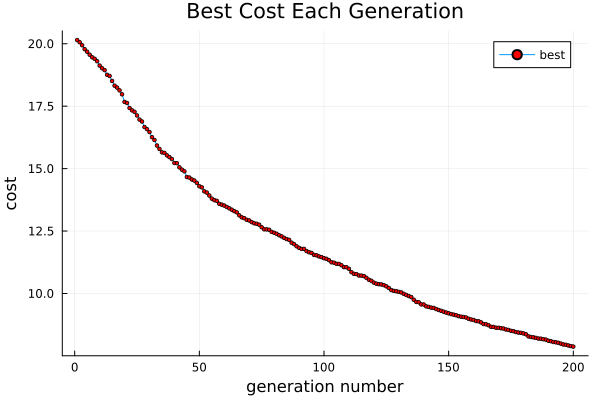

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  405.348 ms … 575.150 ms  ┊ GC (min … max): 4.98% … 4.82%
 Time  (median):     480.315 ms               ┊ GC (median):    5.00%
 Time  (mean ± σ):   472.918 ms ±  59.025 ms  ┊ GC (mean ± σ):  4.96% ± 0.22%

  █   ▁  ▁  ▁               ▁ ▁    ▁          ▁    ▁          ▁  
  █▁▁▁█▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█ ▁
  405 ms           Histogram: frequency by time          575 ms <

 Memory estimate: 475.68 MiB, allocs estimate: 3860414.

In [9]:
num_intervals = 80
fitness_histories = []

for i = 1:monte_carlo_sims

    solution, fitness, fitness_history = continuous_ant_algo(ackley, dimensions, num_generations, num_ants, alpha, Q, rho, tau_naught, num_intervals, mutation_rate, num_ants)
    #println(fitness)
    push!(fitness_histories, fitness_history)
end

averaged_fitness_histories = mean(fitness_histories)
#println(averaged_fitness_histories)
plt1 = display(plot(1:1:num_generations, averaged_fitness_histories, title="Best Cost Each Generation", xlabel="generation number", ylabel="cost", label="best", marker=(:circle,2), mc=:red, reuse = false))
@benchmark solution, fitness, fitness_history = continuous_ant_algo(ackley, dimensions, num_generations, num_ants, alpha, Q, rho, tau_naught, num_intervals, mutation_rate, num_ants)


The computation time of the 80 interval algorithm is about 49% longer (411ms for 80 intervals/275ms for 50 intervals). 

Both experiments have similar slope/convergence performance.  Neither seems to have converged after 200 generations, but the performance is starting to flatten for both.  The 40 interval experiment reached an average cost of 10 at around 125 and the 80 interval experiment at around 110.  Therefore the 80 interval experiment shows a faster convergence.  The end performance difference between both experiments after 200 generations appears neglible.

## .b) 

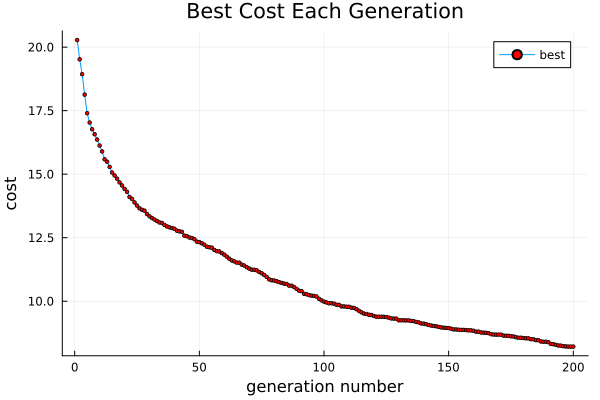

BenchmarkTools.Trial: 47 samples with 1 evaluation.
 Range (min … max):   95.688 ms … 133.536 ms  ┊ GC (min … max): 3.87% … 6.26%
 Time  (median):     105.300 ms               ┊ GC (median):    4.32%
 Time  (mean ± σ):   106.923 ms ±   9.052 ms  ┊ GC (mean ± σ):  4.65% ± 0.96%

   ▁ ▁ █▄     ▁ ▁▄ ▁   ▁▄ ▁              ▁                       
  ▆█▆█▆██▆▆▆▁▁█▆██▆█▆▁▆██▆█▁▁▁▁▆▆▁▁▁▁▆▆▁▁█▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▆▁▁▆ ▁
  95.7 ms          Histogram: frequency by time          134 ms <

 Memory estimate: 115.55 MiB, allocs estimate: 1483141.

In [10]:
num_intervals = 20
num_ants = 40
num_best_ants_used = 4
fitness_histories = []

for i = 1:monte_carlo_sims
    solution, fitness, fitness_history = continuous_ant_algo(ackley, dimensions, num_generations, num_ants, alpha, Q, rho, tau_naught, num_intervals, mutation_rate, num_best_ants_used)
    #println(fitness)
    push!(fitness_histories, fitness_history)
end

averaged_fitness_histories = mean(fitness_histories)
#println(averaged_fitness_histories)
plt1 = display(plot(1:1:num_generations, averaged_fitness_histories, title="Best Cost Each Generation", xlabel="generation number", ylabel="cost", label="best", marker=(:circle,2), mc=:red, reuse = false))
@benchmark solution, fitness, fitness_history = continuous_ant_algo(ackley, dimensions, num_generations, num_ants, alpha, Q, rho, tau_naught, num_intervals, mutation_rate, num_best_ants_used)


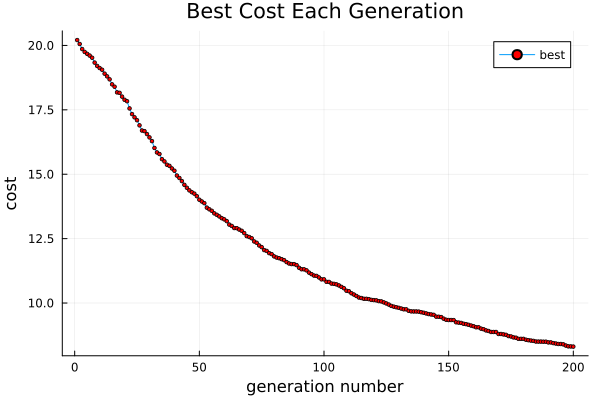

BenchmarkTools.Trial: 25 samples with 1 evaluation.
 Range (min … max):  179.868 ms … 236.260 ms  ┊ GC (min … max): 5.37% … 3.39%
 Time  (median):     197.307 ms               ┊ GC (median):    5.16%
 Time  (mean ± σ):   201.709 ms ±  18.727 ms  ┊ GC (mean ± σ):  4.78% ± 0.91%

  █             ▁                                                
  █▆▆▆▁▁▁▆▁▁▁▁▁▆█▁▁▆▆▁▆▁▆▆▁▁▁▁▁▁▁▁▁▁▁▆▁▁▆▆▁▁▁▁▁▁▁▆▁▆▆▆▁▁▆▁▁▁▁▁▆ ▁
  180 ms           Histogram: frequency by time          236 ms <

 Memory estimate: 140.05 MiB, allocs estimate: 3088735.

In [11]:
num_best_ants_used = 40
fitness_histories = []

for i = 1:monte_carlo_sims
    solution, fitness, fitness_history = continuous_ant_algo(ackley, dimensions, num_generations, num_ants, alpha, Q, rho, tau_naught, num_intervals, mutation_rate, num_best_ants_used)
    # println(fitness)
    push!(fitness_histories, fitness_history)
end

averaged_fitness_histories = mean(fitness_histories)
#println(averaged_fitness_histories)
plt1 = display(plot(1:1:num_generations, averaged_fitness_histories, title="Best Cost Each Generation", xlabel="generation number", ylabel="cost", label="best", marker=(:circle,2), mc=:red, reuse = false))
@benchmark solution, fitness = continuous_ant_algo(ackley, dimensions, num_generations, num_ants, alpha, Q, rho, tau_naught, num_intervals, mutation_rate, num_best_ants_used)

The computation time of the M=40 algorithm is about 80% longer (193ms for M=40/107ms for 50 intervals). 

M=4 shows a steeper initial slope and a faster convergence. The curve of M=4 is much flatter towards the final generation when compared to M=40.  Neither seems to have converged after 200 generations.  The M=4 interval experiment reached an average cost of 10 at around 105 and the M=40 interval experiment at around 130.  The end performance difference after 200 generations appears neglible.

## Verification of Ackley Function

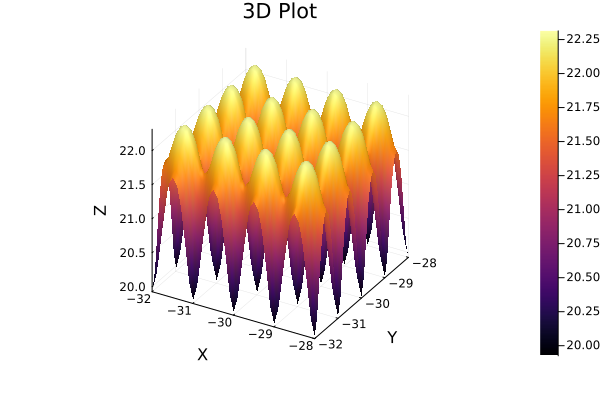

In [67]:
x_values = -32:.1:-28
y_values = -32:.1:-28
z_values = [ackley([i, j]) for i in x_values, j in y_values]
Plots.surface(x_values, y_values, z_values, xlabel="X", ylabel="Y", zlabel="Z", title="3D Plot")